In [3]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

import sys
sys.path.append('library')
import helpers_local
import helioshelp
import mplhelp

Set global label/tick font sizes
---

In [4]:
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
figwidth = 6

Import data
---
Import everything from the corefit dataset from both Helios 1/Helios 2

In [6]:
corefit = helioshelp.load_data()

Loaded corefit data
Start date: (Timestamp('1974-12-12 01:38:10'), '1')
End date: (Timestamp('1984-08-15 23:33:14'), '1')
Number of data points: 2173243
Keys:
Index(['B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument', 'Status',
       'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp'],
      dtype='object')


Remove solar maximum data
-----

In [7]:
corefit = helpers_local.remove_solar_max(corefit)

Number of points: 1093606


Remove CMEs
---

In [8]:
corefit = helioshelp.remove_CMEs(corefit)

Removing CMEs
Removed 5018 points


Calculate derived quantities
----

In [9]:
corefit = helioshelp.calculate_derived(corefit)

New keys:
 Index(['B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument', 'Status',
       'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp', '|B|', '|v|', 'Tp_tot', 'p_mag', 'p_th_par', 'p_th_tot',
       'Beta', 'Beta_tot', 'Tani', 'n_p_norm', 'mass_flux', 'Entropy', 'va_x',
       'va_y', 'va_z', '|va|'],
      dtype='object')


Create downsampled 20 minute means
---

In [10]:
period = '20T'
corefit_downsampled = corefit.groupby(level='Probe').resample(period, level='Time').mean()

Calculate correlations
---

In [11]:
vbs = corefit[['vp_x', 'vp_y', 'vp_z', 'va_x', 'va_y', 'va_z']].dropna()
# Calculate correlations
out = helioshelp.apply_downsampled_function(vbs, helpers_local.correl, '20T', 10)
# corefit_downsampled['sigma_c'], corefit['sigma_c'] = out
# downsampled, corefit = helioshelp.create_correls(corefit, period, min_points)
# print(corefit.keys())

In [12]:
corefit['sigma_c'] = out[1].reindex(corefit.index)
corefit_downsampled['sigma_c'] = out[0].reindex(corefit_downsampled.index)

Method to compute 2D histogram in Beta-Anisotropy plane
---

In [13]:
def calc_hist(data, nbins=30):
    """
    Returned histogram values are number of points in each bin
    divided by the number of points in the largest bin
    """
    xedges = np.logspace(-3, 2, nbins)
    yedges = np.logspace(-1, 1, nbins)
    
    data = data.dropna(subset=('Beta', 'Tani'))

    # Un-normalised histogram so we can throw away bins with a small number of observations
    minobs = 20
    hist, _, _ = np.histogram2d(data['Beta'], data['Tani'],
                                bins=(xedges, yedges), normed=False)
    hist[hist == 0] = np.nan
    # hist[hist < minobs] = np.nan
    hist = hist.T
    hist = hist / np.nanmax(hist)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    xcenters, ycenters = np.meshgrid(xcenters, ycenters)
    return hist, xcenters, ycenters

Method to filter data by two distances
---

In [14]:
def distance_filter(df, lower_r, upper_r):
    return df.iloc[(df['r_sun'].values > lower_r) & (df['r_sun'].values < upper_r)]

Method to setup anisotropy axes
---

In [15]:
def setup_anibeta_axis(ax, title=''):
    ax.cla()
    ax.set_title(title)
    ax.set_xscale('log') 
    ax.set_yscale('log')
    ax.set_xlim(2e-2, 5e0)
    ax.set_ylim(2e-1, 2e1)
    # plot_instability_lines(ax)

Fast and slow solar wind overview
--
Plot both fast/slow solar wind distributions at 0.3 AU and 1 AU (same idea as Matteini 2007)

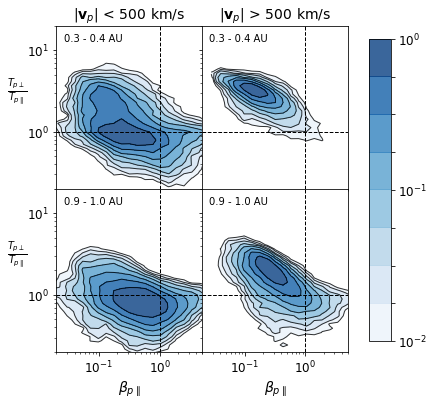

In [30]:
fast_wind = corefit.loc[corefit['vp_x'] > 500]
slow_wind = corefit.loc[corefit['vp_x'] < 500]

titles = {'fast': r'$|\mathbf{v}_{p}|$ > 500 km/s',
          'slow': r'$|\mathbf{v}_{p}|$ < 500 km/s'}
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,
                        facecolor='w', figsize=(figwidth, figwidth))
for wind, windname, axcol in zip((slow_wind, fast_wind), ('slow', 'fast'), axs.T):
    point3au = distance_filter(wind, 0.3, 0.4)
    point9au = distance_filter(wind, 0.9, 1.0)
    for distance, ax in zip((point3au, point9au), axcol):
        setup_anibeta_axis(ax)

        # 0.3 AU
        hist, x, y = calc_hist(distance, 40)
        clevels = np.logspace(-2, 0, 9)
        c = ax.contourf(x, y, hist, clevels, cmap='Blues', norm=mcolor.LogNorm(), alpha=0.8)
        ax.contour(x, y, hist, clevels, norm=mcolor.LogNorm(),
                   linewidths=1, colors='k', alpha=0.8)
        ax.axhline(1, color='k', linewidth=1, linestyle='--')
        ax.axvline(1, color='k', linewidth=1, linestyle='--')

for ax in axs[:, 0]:
    ax.set_ylabel(r'$\frac{T_{p\perp}}{T_{p\parallel}}$', rotation=0, labelpad=10)
for ax in axs[-1, :]:
    ax.set_xlabel(r'$\beta_{p\parallel}$')
axs[0, 0].set_title(r'$|\mathbf{v}_{p}|$ < 500 km/s')
axs[0, 1].set_title(r'$|\mathbf{v}_{p}|$ > 500 km/s')
for ax in axs[0, :]:
    ax.text(0.05, 0.9, '0.3 - 0.4 AU', transform=ax.transAxes)
for ax in axs[1, :]:
    ax.text(0.05, 0.9, '0.9 - 1.0 AU', transform=ax.transAxes)
    
# Add colorbar
fig.subplots_adjust(right=0.8, hspace=0, wspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(c, cax=cbar_ax, extend='min')

fig.savefig('figure_1.pdf', bbox_inches='tight')

Plot histogram of temperature anisotropy at 0.3 AU
---

163998 points (0.3 AU)
225231 points (0.9 AU)


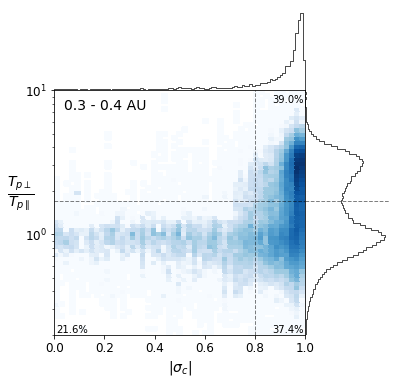

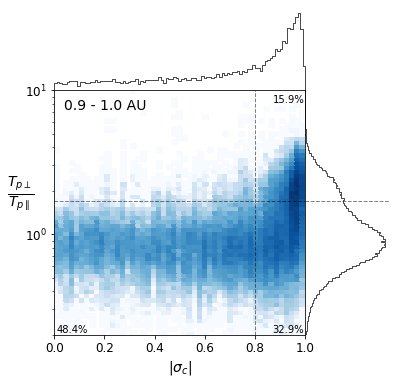

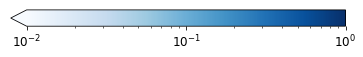

In [29]:
ani_cut = helpers_local.ani_cut
correl_cut = helpers_local.correl_cut
hist_1D_kwargs = dict(histtype='step', color='k', linewidth=0.7)

from matplotlib.gridspec import GridSpec
def create_plots():
    # Loop through two distances
    for j, distance in enumerate((0.3, 0.9)):
        fig = plt.figure(facecolor='w', figsize=(figwidth, figwidth))
        ax2d, ax_cross, ax1d = mplhelp.create_2d_1d_hist_axes(fig)
        fig.subplots_adjust(hspace=0, wspace=0)
        # Setup axis
        ax2d.set_xlim(0, 1)
        ax2d.set_yscale('log')
        ax2d.text(0.04, 0.92, '{} - {} AU'.format(distance, distance + 0.1),
                  transform=ax2d.transAxes,
                  size=matplotlib.rcParams['figure.titlesize'])

        # Filter data and drop nans
        data = distance_filter(corefit, distance, distance + 0.1)
        data = data[['sigma_c', 'Tani']].dropna()
        npoints = data.shape[0]
        print('{} points ({} AU)'.format(npoints, distance))
        
        sigma_c = data['sigma_c'].values
        Tani = data['Tani'].values

        # Calculate 2D histogram
        xedges = np.linspace(0, 1, 50)
        yedges = np.logspace(np.log10(0.2), 1, 60)
        ax2d.set_ylim(bottom=np.min(yedges), top=np.max(yedges))
        hist, _, _ = np.histogram2d(sigma_c, Tani,
                                    bins=[xedges, yedges])
        # hist[hist < 20] = np.nan
        hist = hist.T / np.nanmax(hist)# , axis=1)
        c = ax2d.pcolormesh(xedges, yedges, hist,
                            cmap='Blues', norm=mcolor.LogNorm(), vmin=0.01,
                            edgecolors='face')

        # Plot 1D distribution of anisotropy
        bins = mplhelp.auto_logspaced_bins(Tani)
        ax1d.hist(Tani, orientation='horizontal', bins=bins,
                  **hist_1D_kwargs)
        
        # Plot 1D distribution of cross helicity
        hist, bin_edges = np.histogram(np.abs(sigma_c), bins=np.linspace(0, 1, 100))
        hist = np.concatenate(([0], hist, [0, 0]))
        bin_edges = np.concatenate(([0], bin_edges, [1]))
        ax_cross.step(bin_edges, hist, where='post', linewidth=0.7, color='k', clip_on=False)
        ax_cross.set_ylim(bottom=0)
        ax_cross.set_xlim(0, 1)

        # Axis formatting
        ax2d.set_ylabel(r'$\frac{T_{p\perp}}{T_{p\parallel}}$', rotation=0, size=20)
        ax2d.set_xlabel('|$\sigma_{c}|$')
        if True:
            hline_kwargs = {'linewidth': 1, 'color': 'k', 'linestyle': '--', 'alpha': 0.5}
            ax1d.axhline(ani_cut, **hline_kwargs)
            ax2d.axhline(ani_cut, **hline_kwargs)
            ax2d.axvline(correl_cut, **hline_kwargs)

        # Add population fractions
        if True:
            frac = np.sum((Tani > ani_cut) & (np.abs(sigma_c) > correl_cut)) / npoints
            ax2d.text(0.87, 0.95, '{:.1f}%'.format(frac * 100), transform=ax2d.transAxes)
            
            frac = np.sum((Tani < ani_cut) & (np.abs(sigma_c) > correl_cut)) / npoints
            ax2d.text(0.87, 0.01, '{:.1f}%'.format(frac * 100), transform=ax2d.transAxes)
            
            frac = np.sum((Tani < ani_cut) & (np.abs(sigma_c) < correl_cut)) / npoints
            ax2d.text(0.01, 0.01, '{:.1f}%'.format(frac * 100), transform=ax2d.transAxes)
            
            # frac = data.loc[(data['Tani'] > ani_cut) & (data['sigma_c'].abs() < correl_cut)].shape[0] / npoints
        fig.savefig('figure_3_{}.pdf'.format(int(distance * 10)), bbox_inches='tight')

    fig, ax = plt.subplots(figsize=(figwidth, figwidth / 20))
    fig.colorbar(c, cax=ax, extend='min', orientation='horizontal')
    fig.savefig('figure_3_colorbar.pdf', bbox_inches='tight')

create_plots()

Histograms of velocity in three different categories
---

In [20]:
def population_compare(var, bins='auto', log=False, ax=None, labels=True):
    isotropic = corefit['Tani'] < ani_cut
    anisotropic = corefit['Tani'] > ani_cut
    alfvenic = corefit['sigma_c'].abs() > correl_cut
    nonalfvenic = corefit['sigma_c'].abs() < correl_cut
    total_points = distance_filter(corefit, 0.3, 0.4).dropna(subset=['sigma_c', 'Tani']).shape[0]

    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.6))

    linewidth = 1
    colours = ['C0', 'C3', 'k']
    box_locs = [(165, 0.0065), (400, 0.0065), (700, 0.003)]
    i = 0
    for ani, aniname in zip((isotropic, anisotropic), ('Isotropic', 'Anisotropic')):
        for alf, alfname in zip((alfvenic, nonalfvenic), ('Alfvénic', 'non-Alfvénic')):
            if (alfname == 'non-Alfvénic') and (aniname == 'Anisotropic'):
                continue
            wind = corefit.loc[ani & alf]
            inner = distance_filter(wind, 0.3, 0.4)
            ax.hist(inner[var], bins=bins, density=True, histtype='step',
                    linewidth=linewidth, color=colours[i])
            n = inner.shape[0]
            if var == 'vp_x' and labels:
                ax.text(*box_locs[i],
                        '{}\n{}'.format(aniname, alfname),
                        bbox=dict(facecolor='none', edgecolor=colours[i], pad=3, linewidth=linewidth),
                        multialignment='center')
            i += 1

    # ax.set_title('0.3 AU - 0.4 AU')
    ax.set_ylabel('Probability density')
    return fig, ax

[0.3 0.5 0.7 0.9]
[0.3 0.5 0.7 0.9]
[0.3 0.5 0.7 0.9]


/Users/dstansby/miniconda3/envs/categorisation/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


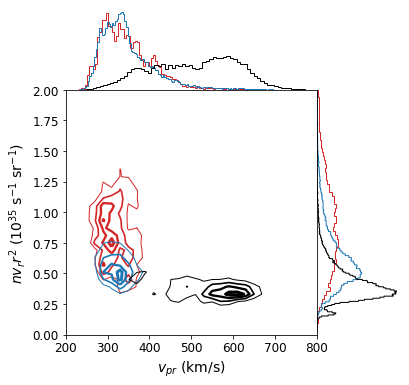

In [31]:
fig = plt.figure(figsize=(figwidth, figwidth))
ax2d, ax_top, ax_right = mplhelp.create_2d_1d_hist_axes(fig)
fig.subplots_adjust(hspace=0, wspace=0)

wind = distance_filter(corefit, 0.3, 0.4)
wind = wind.dropna(subset=('Tani', 'sigma_c'))

Tani = wind['Tani'].values
sigma_c = wind['sigma_c'].values
isotropic = Tani < ani_cut
anisotropic = Tani > ani_cut
alfvenic = np.abs(sigma_c) > correl_cut
nonalfvenic = np.abs(sigma_c) < correl_cut
for  conditions, color in zip((anisotropic & alfvenic, isotropic & alfvenic, isotropic & nonalfvenic)[::-1],
                             ('k', 'C0', 'C3')[::-1]):
    data = wind.iloc[conditions]
    data = data.dropna(subset=('vp_x', 'mass_flux'))
    
    flux_scale = 1e35
    dv, dflux = 20, 0.06
    bins = [np.arange(200, 801, dv), np.arange(0, 1.6, dflux)]
    hist, xedges, yedges = np.histogram2d(data['vp_x'].values, 
                                          data['mass_flux'].values / flux_scale,
                                          (bins[0], bins[1]))
    hist[hist < 10] = 0
    hist = hist / np.max(hist)
    levels = np.arange(0.3, 1.01, 0.2)
    print(levels)
    X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
    hist_sorted = np.cumsum(np.sort(hist.ravel()) / np.cumsum(hist))
    ax2d.contour(X, Y, hist.T, colors=color, levels=np.sort(levels), linewidths=np.linspace(1, 3, len(levels)))
    
    ax_top.hist(data['vp_x'].values, bins='auto',
                color=color, histtype='step', density=True)
    
    ax_right.hist(data['mass_flux'].values / flux_scale, bins='auto',
                  color=color, histtype='step', orientation='horizontal', density=True)

ax2d.set_ylim(bottom=0, top=2)
ax2d.set_ylabel('$nv_{r}r^{2}$ (10$^{35}$ s$^{-1}$ sr$^{-1}$)')
ax2d.set_xlabel(r'$v_{pr}$ (km/s)')
ax2d.set_xlim(200, 800)

ax_right.set_xlim(left=0)
fig.savefig('figure_4.pdf', bbox_inches='tight')

Plot p(anisotropy | velocity) and p(entropy | velocity)
---

/Users/dstansby/miniconda3/envs/categorisation/lib/python3.7/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


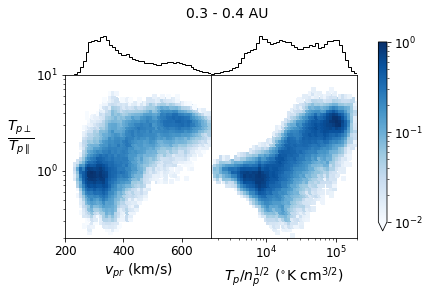

In [32]:
bins = {'vp_x': np.arange(200, 701, 10),
        'Entropy': np.logspace(3.2, 5 + np.log10(2), 50)}
labels = {'vp_x': r'$v_{pr}$ (km/s)',
          'Entropy': r'$T_{p} / n_{p}^{1/2}$ ($^{\circ}$K cm$^{3/2}$)'}
Tanibins = np.logspace(np.log10(2) - 1, 1, 49)

nplots = 2
distance = 0.3
# Loop through two distances
gs = GridSpec(2, nplots, height_ratios=[1, 4], wspace=0, hspace=0)
print(gs[0, :])
fig = plt.figure(figsize=(figwidth, figwidth * 5 / 8))
axs1d = []
axs2d = []
for j in range(nplots):
    ax1d = fig.add_subplot(gs[0, j])
    axs1d.append(ax1d)
    ax2d = fig.add_subplot(gs[1, j], sharex=ax1d)
    axs2d.append(ax2d)
    if j != 0:
        axs2d[j].yaxis.set_visible(False)

# Loop through x-axis variables
for j, var in enumerate(('vp_x', 'Entropy')):
    ax = axs2d[j]
    ax1d = axs1d[j]
    # Setup axis
    if var in ('Entropy'):
        ax.set_xscale('log')
    ax.set_xlim(left=np.min(bins[var]), right=np.max(bins[var]))
    ax.set_ylim(bottom=2e-1, top=1e1)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both')
    if j == 0:
        ax.set_ylabel(r'$\frac{T_{p\perp}}{T_{p\parallel}}$',
                      rotation=0, labelpad=15, size=20)
    ax.set_xlabel(labels[var])

    # Get data for current loop
    data = distance_filter(corefit, distance, distance + 0.1)
    data = data.dropna(subset=[var, 'Tani'])

    # Bin edges
    xedges = bins[var]
    yedges = Tanibins

    # Calculate histogram
    hist, _, _ = np.histogram2d(data[var], data['Tani'],
                                bins=[xedges, yedges])
    vmin = 10
    hist[hist < vmin] = np.nan
    hist = hist.T / np.nanmax(hist)

    # Plot 2D histogram
    c = ax.pcolormesh(xedges, yedges, hist, cmap='Blues', norm=mcolor.LogNorm(), vmin=1e-2,
                      edgecolors='face')

    # Plot 1D histogram
    ax1d.hist(data[var], bins=bins[var], histtype='step', color='k')
    ax1d.axis('off')

# Add a colorbar
fig.subplots_adjust(right=0.8, wspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    
fig.colorbar(c, cax=cbar_ax, extend='min')    
fig.suptitle('{} - {} AU'.format(distance, distance + 0.1))
fig.savefig('figure_5.pdf', bbox_inches='tight')

Plot 2D histograms of parallel and perpendicular temperatures
---

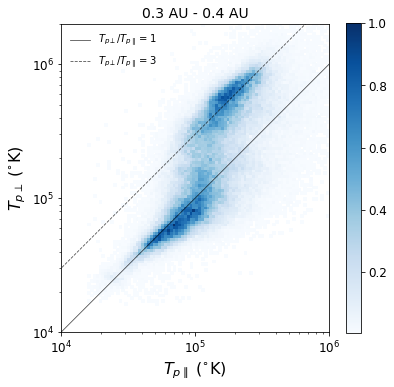

In [28]:
d = 0.3
data = distance_filter(corefit, d, d + 0.1)

lower_lim = 4.2
upper_lim = np.log10(2e6)
# data = data.loc[data['Tp_perp'] < 10**upper_lim]
# data = data.loc[data['Tp_par'] < 10**upper_lim]
data = data.dropna(subset=('Tp_perp', 'Tp_par'))
bins = np.logspace(lower_lim, upper_lim, 100)

# Figure prep
fig, axs = plt.subplots(figsize=(figwidth, figwidth))
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_aspect('equal', 'box')

hist, xedges, yedges = np.histogram2d(data['Tp_par'].values, data['Tp_perp'].values,
                                    bins=[bins, bins])
hist = hist.T / np.nanmax(hist)
hist[hist == 0] =np.nan

# Plot 2D histogram
c = axs.pcolormesh(xedges, yedges, hist, cmap='Blues')

# Plot constant anisotropy lines
linekwargs = dict(color='k', lw=0.8, alpha=0.7)
axs.plot([1e4, 1e7], [1e4, 1e7],
         label=r'$T_{p\perp} / T_{p\parallel} = 1$',
         **linekwargs)
axs.plot([1e4 / 3, 1e7 / 3], [1e4, 1e7],
         ls='--', label=r'$T_{p\perp} / T_{p\parallel} = 3$',
         **linekwargs)

# Plot formatting
axs.set_ylabel(r'$T_{p\perp}$ ($^{\circ}$K)', size=16)
axs.set_xlabel(r'$T_{p\parallel}$ ($^{\circ}$K)', size=16)
axs.legend(framealpha=0)
axs.set_xlim(1e4, 1e6)
axs.set_ylim(1e4, 2e6)
axs.set_title('0.3 AU - 0.4 AU')

fig.colorbar(c, shrink=0.95)
fig.savefig('figure_2.pdf', bbox_inches='tight')